In [2]:
import os
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import pandas as pd
import seaborn as sns
import talib as ta
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D

In [45]:
df = pd.DataFrame() #Apple
df = pd.read_csv('/Users/rorymurray/Downloads/DAL.csv', sep =',')
df.columns = ['Ticker','Per','Date','Time','Open','High','Low','Close','Vol']

#Delta
#dal = pd.DataFrame()
#dal = pd.read_csv('/Users/rorymurray/Downloads/DAL.csv', sep =',')
#dal.columns = ['Ticker','Per','Date','Time','Open','High','Low','Close','Vol']

In [46]:
df.tail()

,Ticker,Per,Date,Time,Open,High,Low,Close,Vol
13455,US1.DAL,30,20201106,140000,31.25,31.33,31.24,31.30,22180
13456,US1.DAL,30,20201106,143000,31.31,31.32,31.21,31.23,18595
13457,US1.DAL,30,20201106,150000,31.23,31.24,31.12,31.13,26828
13458,US1.DAL,30,20201106,153000,31.13,31.21,31.04,31.21,35767
13459,US1.DAL,30,20201106,160000,31.22,31.56,31.22,31.43,151620


In [47]:
df['DateTime'] = df[['Date','Time']].apply(lambda x : '{}{}'.format(x[0],x[1]), axis=1) # combine columns
df['DateTime'] = pd.to_datetime(df['DateTime'],format = '%Y%m%d%H%M%S')
df.set_index('DateTime', inplace=True)

del df['Date']
del df['Ticker']
del df['Per']
del df['Time']

In [48]:
#Add features 

df['RSI_14'] = ta.RSI(df["Close"],timeperiod=14)
df['RSI_10'] = ta.RSI(df["Close"],timeperiod=10)
df['RSI_6'] = ta.RSI(df["Close"],timeperiod=6)
df['RSI_2'] = ta.RSI(df["Close"],timeperiod=2)
df['MOM_10'] = ta.MOM(df["Close"], timeperiod=10)
df['MOM_8'] = ta.MOM(df["Close"], timeperiod=8)
df['MOM_4'] = ta.MOM(df["Close"], timeperiod=4)
df['ATR_14'] = ta.ATR(df["High"], df["Low"], df["Close"], timeperiod=14)
df['ATR_10'] = ta.ATR(df["High"], df["Low"], df["Close"], timeperiod=10)
df['ATR_6'] = ta.ATR(df["High"], df["Low"], df["Close"], timeperiod=6)
df['VAR'] = ta.VAR(df["Close"], timeperiod=5, nbdev=1)

df['MA_10'] = ta.MA(df["Close"], timeperiod=10, matype=0)
df['MA_30'] = ta.MA(df["Close"], timeperiod=30, matype=0)
df['MA_50'] = ta.MA(df["Close"], timeperiod=50, matype=0)
df['MA_200'] = ta.MA(df["Close"], timeperiod=200, matype=0)

df['MACD'],macdsignal, macdhist = ta.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

df = df.iloc[200:]

In [69]:


testdf = pd.DataFrame()

num = len(df)*.7 #split 70:30
num = int(num)

testdf = df.iloc[num:,:]
df = df.iloc[:num,:]



In [8]:
df.head()

,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,MOM_4,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-07-25 15:30:00,97.050,97.12,96.930,97.055,184285,20.558188,16.806772,11.944165,6.259684,-0.925,...,-0.335,0.270763,0.265910,0.255672,0.015986,97.507,98.452000,99.0647,97.73815,-0.567822
2016-07-25 16:00:00,97.050,97.33,97.040,97.330,258742,30.471083,31.445614,38.454684,81.914206,-0.710,...,0.110,0.272137,0.268319,0.261393,0.011714,97.436,98.373333,99.0067,97.74485,-0.546681
2016-07-26 10:00:00,96.800,97.96,96.800,97.680,444252,40.625827,45.105333,57.840134,94.078671,-0.510,...,0.455,0.335556,0.357487,0.411161,0.053666,97.385,98.310333,98.9597,97.75160,-0.495968
2016-07-26 10:30:00,97.680,97.87,97.450,97.780,279293,43.179275,48.371126,61.949326,95.722639,-0.220,...,0.730,0.341587,0.363738,0.412634,0.093404,97.363,98.250500,98.9155,97.75925,-0.442606
2016-07-26 11:00:00,97.785,97.79,96.915,96.920,248954,30.879792,30.839512,30.884195,16.574428,-0.610,...,-0.135,0.379688,0.414864,0.489695,0.113216,97.302,98.167833,98.8539,97.76260,-0.464358


In [49]:
  def create_labels(df,col_name, window_size=26):
        """
        Data is labeled as per the logic in research paper
        Label code : BUY => 1, SELL => 0, HOLD => 2
        params :
            df => Dataframe with data
            col_name => name of column which should be used to determine strategy
        returns : numpy array with integer codes for labels with
                  size = total-(window_size)+1
        """

   
        row_counter = 0
        total_rows = len(df)
        df["Label"] = 0 #create label col
        Labelcol = df.columns.get_loc('Label')

        print("Calculating labels")


        while row_counter < total_rows:
            if row_counter >= window_size - 1:
                window_begin = row_counter - (window_size - 1)
                window_end = row_counter
                window_middle = (window_begin + window_end) / 2
                window_middle = int(window_middle)
                
                   
                Min = 10000
                min_index = 0
                Max = 0
                max_index = 0
                
                for i in range(window_begin, window_end + 1):
                    price = df.iloc[i][col_name]
                    if price < Min:
                        Min = price
                        min_index = i
                    if price > Max:
                        Max = price
                        max_index = i

                
                if min_index == window_middle:
                    df.iloc[window_middle,Labelcol] = 1
                else:
                    df.iloc[window_middle,Labelcol] = 0

            row_counter = row_counter + 1
            
create_labels(df,'Close')       
df.head()

Calculating labels


,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-07-25 12:30:00,38.790,38.930,38.76,38.8700,391375,47.439995,52.562670,60.782786,89.829809,0.0990,...,0.222592,0.215013,0.204430,0.005584,38.83485,38.759090,39.428434,38.518288,-0.121108,0
2016-07-25 13:00:00,38.870,39.000,38.84,38.8701,295881,47.444695,52.569342,60.793595,89.843226,-0.0324,...,0.218122,0.209512,0.197025,0.006884,38.83161,38.757260,39.397936,38.529489,-0.105995,0
2016-07-25 13:30:00,38.880,38.910,38.80,38.9000,281494,48.915665,54.686669,64.322018,94.322397,-0.0510,...,0.210399,0.199561,0.182521,0.006378,38.82651,38.752927,39.365936,38.539614,-0.090562,0
2016-07-25 14:00:00,38.890,38.930,38.84,38.8454,267191,46.363718,50.144809,53.726650,36.130257,-0.1696,...,0.201799,0.188605,0.167101,0.001359,38.80955,38.746440,39.331844,38.550641,-0.081793,0
2016-07-25 14:30:00,38.845,38.905,38.81,38.8850,375406,48.463740,53.272237,59.528768,66.294147,-0.0650,...,0.194170,0.179244,0.155084,0.000329,38.80305,38.738773,39.298644,38.561666,-0.070832,0


In [106]:
  def trend_labels(df, col_name, window_size=11, threshold = 3):

        row_counter = 0
        total_rows = len(df)
        df["Label"] = 0 #create label col
        Labelcol = df.columns.get_loc('Label')

        print("trend labels")


        while row_counter < total_rows:
            if row_counter >= window_size - 1:
                window_begin = row_counter - (window_size - 1)
                window_end = row_counter
                window_middle = (window_begin + window_end) / 2

                Min = 10000
                min_index = 0
                Max = 0
                max_index = 0
                
                for i in range(window_begin, window_end + 1):
                    price = df.iloc[i][col_name]
                    if price < Min:
                        Min = price    #find min
                        min_index = i
                    if price > Max:
                        Max = price    #find max
                        max_index = i

                if(min_index +98 < len(df)): 
                    #98 is a week forward 
                    diff = df.iloc[min_index+98][col_name] - df.iloc[min_index][col_name]
                    change = diff / df.iloc[min_index][col_name] * 100 
                 
                    if(change > threshold):
                        df.iloc[min_index,Labelcol] = 1  #buy
                    else:
                        df.iloc[min_index,Labelcol] = 0  #hold
                        
                        #elif(decrease < threshold * -1):
                        #df.at[min_index,'Label'] = 0  #short
                
                    
         
                
            row_counter = row_counter + 1
            
            
        
            
trend_labels(df,'Close') 
df.head()

trend labels


,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-07-25 15:30:00,97.050,97.12,96.930,97.055,184285,20.558188,16.806772,11.944165,6.259684,-0.925,...,0.270763,0.265910,0.255672,0.015986,97.507,98.452000,99.0647,97.73815,-0.567822,0
2016-07-25 16:00:00,97.050,97.33,97.040,97.330,258742,30.471083,31.445614,38.454684,81.914206,-0.710,...,0.272137,0.268319,0.261393,0.011714,97.436,98.373333,99.0067,97.74485,-0.546681,0
2016-07-26 10:00:00,96.800,97.96,96.800,97.680,444252,40.625827,45.105333,57.840134,94.078671,-0.510,...,0.335556,0.357487,0.411161,0.053666,97.385,98.310333,98.9597,97.75160,-0.495968,0
2016-07-26 10:30:00,97.680,97.87,97.450,97.780,279293,43.179275,48.371126,61.949326,95.722639,-0.220,...,0.341587,0.363738,0.412634,0.093404,97.363,98.250500,98.9155,97.75925,-0.442606,0
2016-07-26 11:00:00,97.785,97.79,96.915,96.920,248954,30.879792,30.839512,30.884195,16.574428,-0.610,...,0.379688,0.414864,0.489695,0.113216,97.302,98.167833,98.8539,97.76260,-0.464358,0


In [77]:
df[2000:2100]

,Open,High,Low,Close,Vol,Label
DateTime,,,,,,
2017-02-10 11:30:00,49.1600,49.180,49.02,49.1250,311054,0
2017-02-10 12:00:00,49.1250,49.230,49.09,49.2000,261522,0
2017-02-10 12:30:00,49.2100,49.300,49.18,49.2799,223822,0
2017-02-10 13:00:00,49.2700,49.340,49.18,49.1850,224616,1
2017-02-10 13:30:00,49.1900,49.380,49.18,49.3500,265410,0
...,...,...,...,...,...,...
2017-02-22 13:30:00,50.7600,50.780,50.69,50.7590,213398,0
2017-02-22 14:00:00,50.7551,50.790,50.68,50.7340,289940,0
2017-02-22 14:30:00,50.7400,50.815,50.59,50.8000,226765,0


In [191]:
len(df)

13460

In [246]:
df.head()

,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-07-25 12:30:00,38.790,38.930,38.76,38.8700,391375,47.439995,52.562670,60.782786,89.829809,0.0990,...,0.222592,0.215013,0.204430,0.005584,38.83485,38.759090,39.428434,38.518288,-0.121108,0
2016-07-25 13:00:00,38.870,39.000,38.84,38.8701,295881,47.444695,52.569342,60.793595,89.843226,-0.0324,...,0.218122,0.209512,0.197025,0.006884,38.83161,38.757260,39.397936,38.529489,-0.105995,0
2016-07-25 13:30:00,38.880,38.910,38.80,38.9000,281494,48.915665,54.686669,64.322018,94.322397,-0.0510,...,0.210399,0.199561,0.182521,0.006378,38.82651,38.752927,39.365936,38.539614,-0.090562,0
2016-07-25 14:00:00,38.890,38.930,38.84,38.8454,267191,46.363718,50.144809,53.726650,36.130257,-0.1696,...,0.201799,0.188605,0.167101,0.001359,38.80955,38.746440,39.331844,38.550641,-0.081793,0
2016-07-25 14:30:00,38.845,38.905,38.81,38.8850,375406,48.463740,53.272237,59.528768,66.294147,-0.0650,...,0.194170,0.179244,0.155084,0.000329,38.80305,38.738773,39.298644,38.561666,-0.070832,0


In [50]:
df['Label'].value_counts()


0    12899
1      361
Name: Label, dtype: int64

In [69]:
def buy(df,bal,holdings,priceindex):
    
    close = df.columns.get_loc("Close") # get index of close col
    
    buyprice = df.iloc[priceindex,close]
    sellprice = df.iloc[priceindex+13,close] #sell price 100 timesteps forward
    
    buytotal = 10 * buyprice
    
    #print("buyprice : ",buyprice," sell : ",sellprice , "pl ",(sellprice-buyprice)/buyprice)
    
    bal = bal - buytotal #10 shares bought
    newposition = Position(buyprice,sellprice)
    
    return bal,holdings,newposition
              
    
        

        
        
        
def sell(bal,holdings,price):
    selltotal = 10*price
    bal = bal + selltotal

        
    return bal,holdings

def sellall(bal,holdings,price,shares):
    total = shares * price
    holdings = 0 
    bal = total
    shares = 0 
    return bal,holdings

In [70]:
class Position:
    def __init__(self, buyprice, sellprice):
        
        self.buyprice = buyprice
        self.sellprice = sellprice
      

    def get_sellprice(self):
        return sellprice
        
    def get_buyprice(self):
        return buyprice

In [71]:
# Paper Trade 
#works buy buying when label 1, balance is updated and a new position object is created until the 
#position is finally closed 

def paperTrade(df):
    
    balance = 100000
    stockholdings = 0
    numShares = 0
    Labelcol = df.columns.get_loc("Label") # get index of label col
    close = df.columns.get_loc("Close")


    buylist = []  #list to store buy positions 

    for i in range(len(df)):
        if df.iloc[i,Labelcol] == 1:
            if balance > 10 * df.iloc[i,close] and i+100<len(df):
                
                balance,stockholdings,position = buy(df,balance,stockholdings,i)
                #print(balance)
                buylist.append(position)
                
                
        
        
    
        if len(buylist) != 0:  #buylist not empty 
            for t in buylist:
                pos = t
                sellprice = pos.sellprice
            
                if(df.iloc[i,close] >= sellprice):
                    balance,stockholdings = sell(balance,stockholdings,sellprice)
                  
                    buylist.remove(pos)
                    del pos
                
                
                
    print(len(buylist))               
    balance = float(str(round(balance, 2))) #rounding 
    stockholdings = float(str(round(stockholdings,2))) 
 

    print('Final balance : ',balance)   #print outputs
    print('Final holdings : ', stockholdings)
    pl =  balance - 100000
    pl_percentage = pl/100000 *100
    print( "P&L : ", pl,'  Gain : ',pl_percentage,'%' )
    
    
    
# cnn_pred   
paperTrade(df)

0
Final balance :  103229.29
Final holdings :  0.0
P&L :  3229.2899999999936   Gain :  3.2292899999999936 %


In [17]:
#Buy & Hold
close = df.columns.get_loc("Close")
bal = 100000
holdings = 0 
i = 0 

while i < len(df):
    price = df.iloc[i,close]
    buy = price * 30 
    if buy < bal:
        holdings = holdings + 30
        bal = bal - buy
    else:
        print('out of money')
    
    i += 500
    

sellprice = df.iloc[13000,close]
gain = holdings * sellprice 
pl = gain-100000
per = pl/100000 * 100


print(pl, ", Gain : ", per,'%')

out of money
out of money
out of money
out of money
out of money
out of money
out of money
out of money
126398.0 , Gain :  126.39800000000001 %


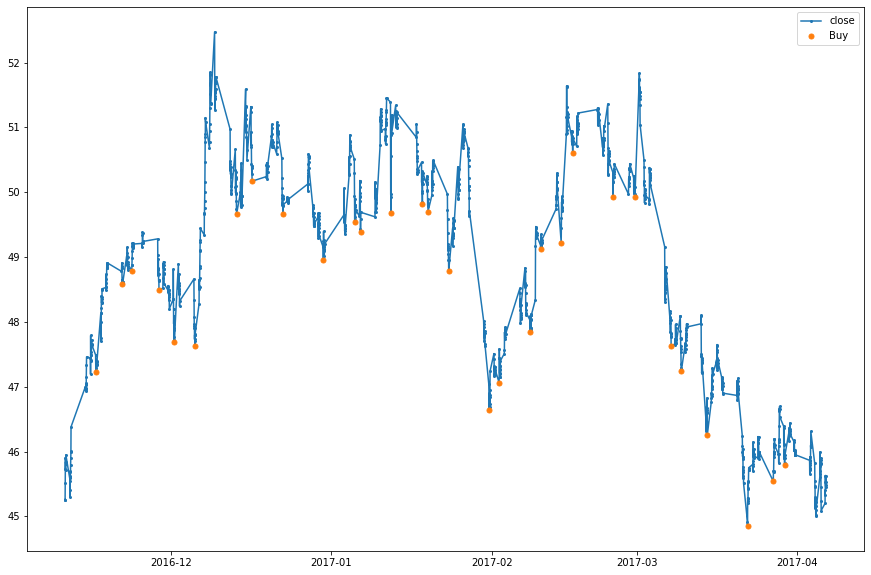

In [44]:
buysignals = df.loc[df['Label'] == 1]


plt.figure(figsize=(15,10))
plt.plot(df['Close'].iloc[1000:2300],'o-',label="close",ms = 2)
plt.plot(buysignals['Close'].iloc[30:60],'o',ms = 5,label = "Buy")
plt.legend()

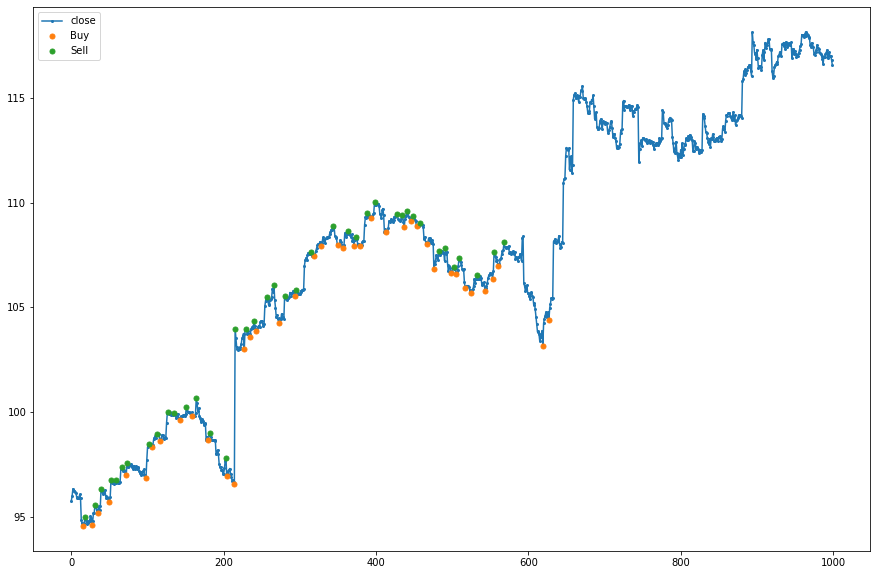

In [23]:
buysignals = df.loc[df['f'] == 1]
sellsignals = df.loc[df['f'] == 0]

plt.figure(figsize=(15,10))
plt.plot(df['Close'].iloc[:1000],'o-',label="close",ms = 2)
plt.plot(buysignals['Close'].iloc[:40],'o',ms = 5,label = "Buy")
plt.plot(sellsignals['Close'].iloc[:40],'o',ms = 5,label = "Sell")
plt.legend()

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaled_df = pd.DataFrame()
scaled_df = df

mm_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = pd.DataFrame(mm_scaler.fit_transform(scaled_df.values), columns=scaled_df.columns, index=scaled_df.index)
#testdf = pd.DataFrame(mm_scaler.fit_transform(testdf.values), columns=testdf.columns, index=testdf.index)

In [251]:
df.iloc[0:20]

,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-07-25 12:30:00,38.7900,38.930,38.7600,38.8700,391375,47.439995,52.562670,60.782786,89.829809,0.0990,...,0.222592,0.215013,0.204430,0.005584,38.83485,38.759090,39.428434,38.518288,-0.121108,0
2016-07-25 13:00:00,38.8700,39.000,38.8400,38.8701,295881,47.444695,52.569342,60.793595,89.843226,-0.0324,...,0.218122,0.209512,0.197025,0.006884,38.83161,38.757260,39.397936,38.529489,-0.105995,0
2016-07-25 13:30:00,38.8800,38.910,38.8000,38.9000,281494,48.915665,54.686669,64.322018,94.322397,-0.0510,...,0.210399,0.199561,0.182521,0.006378,38.82651,38.752927,39.365936,38.539614,-0.090562,0
2016-07-25 14:00:00,38.8900,38.930,38.8400,38.8454,267191,46.363718,50.144809,53.726650,36.130257,-0.1696,...,0.201799,0.188605,0.167101,0.001359,38.80955,38.746440,39.331844,38.550641,-0.081793,0
2016-07-25 14:30:00,38.8450,38.905,38.8100,38.8850,375406,48.463740,53.272237,59.528768,66.294147,-0.0650,...,0.194170,0.179244,0.155084,0.000329,38.80305,38.738773,39.298644,38.561666,-0.070832,0
2016-07-25 15:00:00,38.8800,38.930,38.8500,38.8950,287748,49.006700,54.080470,61.010237,72.785405,0.0850,...,0.186015,0.169320,0.142570,0.000388,38.81155,38.730940,39.265744,38.573241,-0.060640,0
2016-07-25 15:30:00,38.8975,38.930,38.8550,38.9200,378211,50.413218,56.185587,64.868275,86.135710,0.2300,...,0.178086,0.159888,0.131308,0.000607,38.83455,38.739023,39.229744,38.584691,-0.049969,0
2016-07-25 16:00:00,38.9250,38.980,38.8950,38.9600,1026866,52.662986,59.487356,70.477148,94.604877,0.2700,...,0.171437,0.152399,0.123590,0.001445,38.86155,38.748357,39.190344,38.597291,-0.037848,0
2016-07-26 10:00:00,38.9700,39.190,38.9000,39.0500,890275,57.351574,65.909788,79.369971,98.560870,0.3700,...,0.179905,0.166159,0.151325,0.003586,38.89855,38.765357,39.148344,38.610141,-0.020741,0


In [12]:
def create_images(df, n_steps):
    X, y = list(), list()
    for i in range(len(df)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(df):
            break
        # gather input and output parts of the pattern
        seq_x ,seq_y= df.iloc[i:end_ix, :-1], df.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [13]:
Xtrain,Ytrain = create_images(scaled_df,30)

In [55]:
len(Xtrain)

13909

In [14]:
num = len(Xtrain)*.7 #split 70:30
num = int(num)

Xtest = Xtrain[num:,:]
Ytest = Ytrain[num:]

Xtrain = Xtrain[:num,:]
Ytrain = Ytrain[:num]



In [22]:
num = len(df)*.7 #split 70:30
num = int(num)
df.iloc[num-7:num+4,:]

,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-07-24 16:00:00,208.530,208.74,208.200,208.63,135618,61.887185,63.115992,68.102446,92.266228,0.70,...,0.577390,0.560098,0.542489,0.288064,207.954,207.893333,206.7953,204.199175,0.315531,0
2019-07-25 10:00:00,208.870,209.22,207.740,208.34,131980,57.469499,56.778118,57.003974,45.468195,0.42,...,0.641862,0.652088,0.698741,0.206096,207.996,207.960333,206.8625,204.226575,0.313091,0
2019-07-25 10:30:00,208.290,208.66,208.080,208.44,50931,58.567794,58.379415,59.720230,59.600014,0.65,...,0.637443,0.644879,0.678951,0.037616,208.061,208.025333,206.9313,204.255825,0.315589,0
2019-07-25 11:00:00,208.520,208.87,208.450,208.55,66586,59.797630,60.182405,62.820634,74.269590,0.68,...,0.622626,0.623391,0.637459,0.009784,208.129,208.082000,207.0109,204.287025,0.322725,0
2019-07-25 11:30:00,208.500,208.68,207.960,208.14,58101,53.431408,51.027780,46.732029,20.035994,0.00,...,0.629581,0.633052,0.651216,0.029240,208.129,208.113000,207.0735,204.317525,0.291931,0
2019-07-25 12:00:00,208.040,208.37,207.900,208.34,39248,55.897944,54.757857,53.676579,53.303392,0.49,...,0.618182,0.616747,0.621013,0.018336,208.178,208.129667,207.1409,204.349075,0.280432,0
2019-07-25 12:30:00,208.350,208.35,207.950,208.06,32389,51.764262,48.957284,44.032504,24.621834,0.66,...,0.602598,0.595072,0.584178,0.033344,208.244,208.126667,207.2023,204.379875,0.245891,0
2019-07-25 13:00:00,208.040,208.14,207.330,207.53,69533,44.983249,40.037292,31.270692,8.107230,0.17,...,0.617412,0.616565,0.621815,0.117064,208.261,208.107000,207.2565,204.407275,0.173748,0
2019-07-25 13:30:00,207.490,207.49,207.120,207.37,41794,43.145732,37.731337,28.299423,5.770397,-0.69,...,0.602597,0.595908,0.586512,0.138776,208.192,208.080333,207.3269,204.433775,0.102482,0


In [139]:
len(Xtest)

3975

In [15]:
unique, counts = np.unique(Ytrain, return_counts=True)
counts

array([9010,  251])

In [133]:
Xtest[0,10,:]

array([ 5.91600000e+01,  5.92200000e+01,  5.91200000e+01,  5.91600000e+01,
        9.12500000e+03,  4.81605758e+01,  4.73057429e+01,  4.30921666e+01,
        2.12183628e+01, -5.45000000e-01, -2.90000000e-01, -3.40000000e-01,
        3.06904649e-01,  2.96293642e-01,  2.62756929e-01,  2.04399999e-02,
        5.93980000e+01,  5.91856667e+01,  5.94464000e+01,  6.06605500e+01,
        1.18044158e-02])

In [16]:
Xtrain.shape

(9261, 30, 21)

In [17]:
def build_model():

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=(3), activation='relu', input_shape=(30,21), padding = 'same'))
    #model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(filters=64, kernel_size=(3), activation='relu',padding = 'same'))
    model.add(MaxPooling1D(pool_size=(4)))


    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation = 'sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'] )
    
    return model



In [18]:
model1 = build_model()

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            2048      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            6208      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 448)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 448)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [20]:
history = model1.fit(Xtrain,Ytrain,epochs=30,verbose=1,class_weight = {0:0.05,1:0.95})



Epoch 1/30
290/290 [==============================] - 2s 4ms/step - loss: 0.0493 - accuracy: 0.8964
Epoch 2/30
290/290 [==============================] - 1s 4ms/step - loss: 0.0456 - accuracy: 0.9557
Epoch 3/30
290/290 [==============================] - 1s 4ms/step - loss: 0.0450 - accuracy: 0.9003
Epoch 4/30
290/290 [==============================] - 1s 5ms/step - loss: 0.0424 - accuracy: 0.8568
Epoch 5/30
290/290 [==============================] - 1s 4ms/step - loss: 0.0403 - accuracy: 0.8564
Epoch 6/30
290/290 [==============================] - 1s 4ms/step - loss: 0.0414 - accuracy: 0.8274
Epoch 7/30
290/290 [==============================] - 1s 4ms/step - loss: 0.0387 - accuracy: 0.8289
Epoch 8/30
290/290 [==============================] - 1s 4ms/step - loss: 0.0385 - accuracy: 0.8144
Epoch 9/30
290/290 [==============================] - 1s 4ms/step - loss: 0.0390 - accuracy: 0.8131
Epoch 10/30
290/290 [==============================] - 1s 4ms/step - loss: 0.0351 - accuracy: 0.8294

In [21]:
results = model1.evaluate(Xtest, Ytest)
print("test loss, test acc:", results)

125/125 [==============================] - 0s 2ms/step - loss: 0.2440 - accuracy: 0.9136
test loss, test acc: [0.24396216869354248, 0.9136019945144653]


In [22]:
predictions = model1.predict(Xtest)

In [23]:
len(predictions)

3970

In [24]:
Xtest[0,0,0]

0.9154991243432574

In [25]:
m = predictions.max()
m

0.8826537

In [26]:
minx = predictions.min()
minx


1.1464688e-05

In [27]:
cnn_pred = pd.DataFrame(columns = ['Close', 'Label'])
num = len(df)*.7 #split 70:30
num = int(num)
num = num +23


for i in range(len(Xtest)):
    if num+i < len(df):
        
        if predictions[i] > 0.5:
            cnn_pred = cnn_pred.append({'Close' : df.iloc[num + i,3] , 'Label' : 1}, ignore_index = True)
        
        else:
            cnn_pred = cnn_pred.append({'Close' : df.iloc[num + i,3] , 'Label' : 0}, ignore_index = True)
        

In [28]:
cnn_pred['Label'].value_counts()



0.0    3617
1.0     338
Name: Label, dtype: int64

In [41]:
paperTrade(cnn_pred)

buyprice :  57.01  sell :  58.03 pl  0.017891597965269308
buyprice :  56.99  sell :  58.095 pl  0.019389366555536004
buyprice :  57.09  sell :  58.21 pl  0.019618146785776797
buyprice :  57.06  sell :  58.28 pl  0.02138100245355764
buyprice :  56.81  sell :  58.23 pl  0.024995599366308654
buyprice :  58.01  sell :  57.51 pl  -0.008619203585588693
buyprice :  55.96  sell :  56.32 pl  0.006433166547533942
buyprice :  56.42  sell :  55.64 pl  -0.013824884792626748
buyprice :  56.43  sell :  55.79 pl  -0.011341485025695562
buyprice :  56.21  sell :  55.88 pl  -0.005870841487279813
buyprice :  56.025  sell :  55.83 pl  -0.0034805890227577025
buyprice :  57.09  sell :  57.95 pl  0.015063934139078637
buyprice :  57.285  sell :  57.22 pl  -0.0011346774897442215
buyprice :  57.47  sell :  58.6 pl  0.019662432573516662
buyprice :  57.27  sell :  58.58 pl  0.022874105116116556
buyprice :  57.26  sell :  58.75 pl  0.02602165560600772
buyprice :  57.3  sell :  58.61 pl  0.0228621291448517
buyprice 

buyprice :  47.0  sell :  45.61 pl  -0.029574468085106394
buyprice :  45.61  sell :  47.25 pl  0.03595702696777024
buyprice :  46.02  sell :  47.99 pl  0.042807475010864814
buyprice :  45.81  sell :  46.82 pl  0.022047587862911982
buyprice :  45.76  sell :  46.63 pl  0.01901223776223786
buyprice :  44.92  sell :  42.38 pl  -0.05654496883348172
buyprice :  23.87  sell :  22.49 pl  -0.05781315458734824
buyprice :  23.595  sell :  22.46 pl  -0.048103411739775295
buyprice :  23.37  sell :  22.48 pl  -0.038083012409071484
buyprice :  22.49  sell :  22.76 pl  0.01200533570475781
buyprice :  22.46  sell :  22.05 pl  -0.01825467497773821
buyprice :  21.88  sell :  22.71 pl  0.0379341864716637
buyprice :  22.48  sell :  22.31 pl  -0.00756227758007125
buyprice :  21.77  sell :  25.5 pl  0.1713367018833257
buyprice :  24.16  sell :  22.91 pl  -0.05173841059602649
buyprice :  23.21  sell :  22.75 pl  -0.019819043515726015
buyprice :  23.3  sell :  23.17 pl  -0.005579399141630859
buyprice :  23.13 

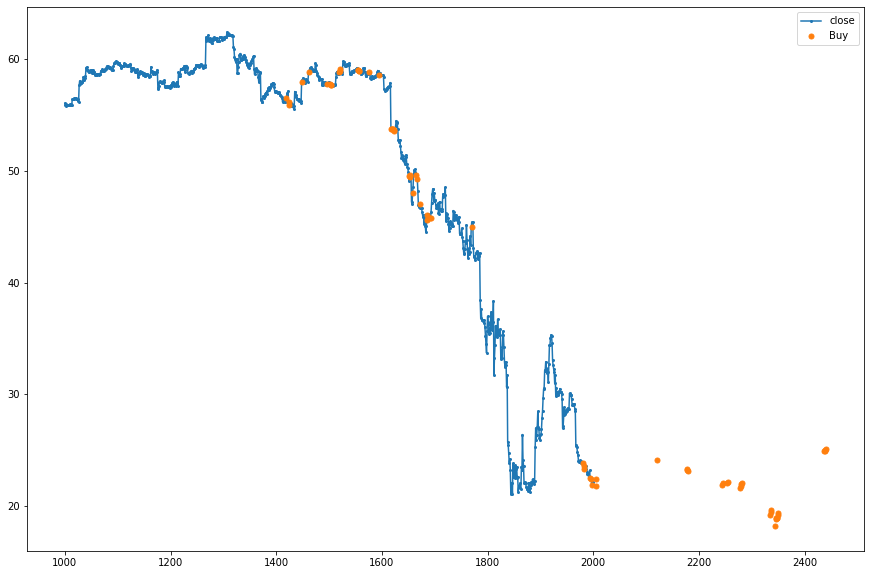

In [39]:
buysignals = cnn_pred.loc[cnn_pred['Label'] == 1]


plt.figure(figsize=(15,10))
plt.plot(cnn_pred['Close'].iloc[1000:2000],'o-',label="close",ms = 2)
plt.plot(buysignals['Close'].iloc[130:200],'o',ms = 5,label = "Buy")
plt.legend()

In [1]:
#




#

In [35]:
num = len(df)*.7 #split 70:30
num = int(num)
num = num +23
df.iloc[num:num +20,:]

,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-08-15 12:00:00,57.03,57.04,56.86,57.010,22649,34.027646,34.003411,35.382912,27.620600,-0.130,...,0.367531,0.368470,0.361935,0.052904,57.2050,58.087333,58.4842,60.101450,-0.443950,0
2019-08-15 12:30:00,57.00,57.08,56.95,56.990,21819,33.731213,33.560132,34.486297,22.268533,-0.260,...,0.350564,0.344623,0.323279,0.001064,57.1790,57.998667,58.4366,60.069750,-0.433011,0
2019-08-15 13:00:00,57.02,57.20,57.02,57.090,19316,36.700484,38.047016,43.132544,73.540101,-0.180,...,0.340524,0.331161,0.304399,0.001256,57.1610,57.920000,58.3854,60.039400,-0.411529,0
2019-08-15 13:30:00,56.98,57.11,56.94,57.060,5800,36.176791,37.209395,41.176204,52.688245,-0.250,...,0.328344,0.315045,0.281999,0.001256,57.1360,57.842000,58.3342,60.010550,-0.392402,0
2019-08-15 14:00:00,57.07,57.10,56.79,56.810,22243,32.069959,30.908756,28.327741,9.202008,-0.510,...,0.327033,0.314540,0.286666,0.009536,57.0850,57.751333,58.2802,59.980100,-0.392887,1
2019-08-15 14:30:00,56.89,57.13,56.81,57.105,11316,40.634046,43.460959,50.291224,69.198318,-0.125,...,0.326531,0.315086,0.292222,0.011664,57.0725,57.666500,58.2327,59.951275,-0.365257,0
2019-08-15 15:00:00,57.09,57.09,56.89,56.990,15958,38.591502,40.290427,43.985731,45.670206,-0.600,...,0.318564,0.305078,0.279351,0.011664,57.0125,57.582833,58.1811,59.922475,-0.348621,0
2019-08-15 15:30:00,57.03,57.16,56.95,56.965,14488,38.142634,39.592760,42.592624,39.788288,-0.005,...,0.310810,0.295570,0.267793,0.010214,57.0120,57.503333,58.1298,59.894500,-0.333609,0
2019-08-15 16:00:00,56.94,57.23,56.93,57.130,45943,42.865988,46.399187,54.104966,77.699721,0.070,...,0.310038,0.296013,0.273161,0.013070,57.0190,57.436333,58.0928,59.867200,-0.304883,0
